<a href="https://colab.research.google.com/github/Artem1s1337/nlp_amazon_reviews/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.73      0.67     51222
           2       0.47      0.14      0.21     27314
           3       0.46      0.33      0.38     42765
           4       0.58      0.29      0.39     79110
           5       0.83      0.96      0.89    407589

    accuracy                           0.77    608000
   macro avg       0.59      0.49      0.51    608000
weighted avg       0.74      0.77      0.74    608000

Accuracy: 0.77
F1 (macro): 0.51

Average score: 4.39
Overall perception: POSITIVE
Predictions saved to predictions.csv


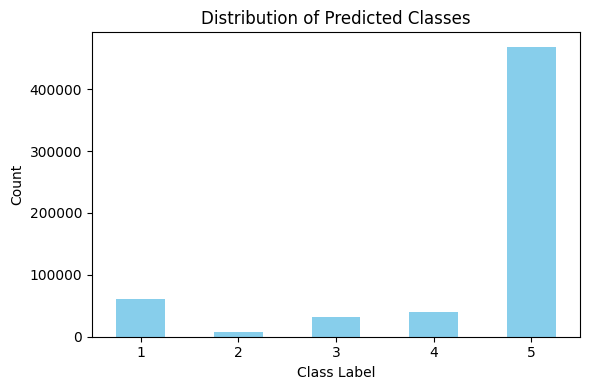

Class distribution plot saved as class_distribution.png

 Предсказания:
Текст: Very bad product
Оценка: 1 (уверенность 0.59)
------------------------------
Текст: Absolutely wonderful! I’ll order again
Оценка: 5 (уверенность 0.99)
------------------------------
Текст: It's okay, but I expected more
Оценка: 3 (уверенность 0.79)
------------------------------


In [2]:
import os
import re
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score


class SimpleSentimentAnalyzer:
    def __init__(self, model_path: str = "sentiment_model.joblib"):
        self.vectorizer = TfidfVectorizer(max_features=1000)
        self.model = LogisticRegression(max_iter=200)
        self.model_path = model_path

    def parse_fasttext_data(self, file_path: str) -> pd.DataFrame:
        texts, labels = [], []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                match = re.match(r'__label__(\d+)\s(.+)', line)
                if match:
                    label = int(match.group(1))
                    text = match.group(2).strip()
                    if text:
                        texts.append(text)
                        labels.append(label)
        return pd.DataFrame({'text': texts, 'label': labels})

    def preprocess_text(self, text: str) -> str:
        return re.sub(r'\s+', ' ', text).strip().lower()

    def prepare_data(self, df: pd.DataFrame, test_size: float = 0.2):
        df['text'] = df['text'].apply(self.preprocess_text)
        X = self.vectorizer.fit_transform(df['text'])
        y = df['label']
        return train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def load_or_train(self, X_train, y_train):
        if os.path.exists(self.model_path):
            print(f"Loading model from {self.model_path}")
            checkpoint = joblib.load(self.model_path)
            self.model = checkpoint["model"]
            self.vectorizer = checkpoint["vectorizer"]
        else:
            print("Training new model...")
            self.train(X_train, y_train)
            joblib.dump({"model": self.model, "vectorizer": self.vectorizer}, self.model_path)
            print(f"Model saved to {self.model_path}")

    def evaluate(self, X_test, y_test):
        preds = self.model.predict(X_test)
        print("\nClassification Report:")
        print(classification_report(y_test, preds))
        print(f"Accuracy: {accuracy_score(y_test, preds):.2f}")
        print(f"F1 (macro): {f1_score(y_test, preds, average='macro'):.2f}")

    def overall_sentiment_score(self, X_test, y_test) -> Dict:
        preds = self.model.predict(X_test)
        mean_score = preds.mean()

        if mean_score < 2.5:
            perception = "negative"
        elif mean_score < 3.5:
            perception = "neutral"
        else:
            perception = "positive"

        print(f"\nAverage score: {mean_score:.2f}")
        print(f"Overall perception: {perception.upper()}")

        distribution = pd.Series(preds).value_counts().sort_index()

        # Сохраняем CSV
        pd.DataFrame({'prediction': preds}).to_csv("predictions.csv", index=False)
        print("Predictions saved to predictions.csv")

        # Строим график
        self.plot_class_distribution(distribution)

        return {
            "mean_score": mean_score,
            "perception": perception,
            "distribution": distribution.to_dict()
        }

    def plot_class_distribution(self, distribution: pd.Series):
        plt.figure(figsize=(6, 4))
        distribution.plot(kind='bar', color='skyblue')
        plt.title("Distribution of Predicted Classes")
        plt.xlabel("Class Label")
        plt.ylabel("Count")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.savefig("class_distribution.png")
        plt.show()
        print("Class distribution plot saved as class_distribution.png")

    def predict(self, texts: List[str]) -> List[Dict]:
        processed = [self.preprocess_text(t) for t in texts]
        X = self.vectorizer.transform(processed)
        probs = self.model.predict_proba(X)
        preds = self.model.predict(X)

        results = []
        for i, text in enumerate(texts):
            predicted_label = preds[i]
            confidence = max(probs[i])
            results.append({
                "text": text,
                "predicted_label": predicted_label,
                "confidence": confidence
            })
        return results



def main():
    analyzer = SimpleSentimentAnalyzer()
    df = analyzer.parse_fasttext_data("/content/train.ft.txt")

    X_train, X_test, y_train, y_test = analyzer.prepare_data(df)

    analyzer.train(X_train, y_train)
    analyzer.evaluate(X_test, y_test)

    summary = analyzer.overall_sentiment_score(X_test, y_test)

    texts = [
        "Very bad product",
        "Absolutely wonderful! I’ll order again",
        "It's okay, but I expected more"
    ]

    preds = analyzer.predict(texts)
    print("\n Предсказания:")
    for p in preds:
        print(f"Текст: {p['text']}")
        print(f"Оценка: {p['predicted_label']} (уверенность {p['confidence']:.2f})")
        print("-" * 30)

if __name__ == "__main__":
    main()
